In [26]:
!pip install jsonlines


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud
from wordcloud import STOPWORDS
import random
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN,LSTM , Dense, Dropout , BatchNormalization
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import Constant
from transformers import BertTokenizer, TFAutoModel
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [6]:
df_train = pd.read_json('/content/drive/My Drive/train.jsonl', lines=True)

df_train.head()

,category,headline,authors,link,short_description,date
0,WELLNESS,Pain's Long Reach and Powerful Grip,"Jim Moret, Contributor\nChief Correspondent, I...",https://www.huffingtonpost.com/entry/dealing-w...,Ask our son about pain. He will tell you about...,2013-09-09
1,POLITICS,Runaway Trump Train Picks Up Speed As Aides Ca...,Howard Fineman and S.V. Date,https://www.huffingtonpost.com/entry/runaway-t...,"Paul Manafort isn’t quitting, but is said to b...",2016-08-03
2,PARENTS,Why Parental Praise Doesn't Create Narcissists...,"Dr. Craig Malkin, ContributorAuthor, Clinical ...",https://www.huffingtonpost.com/entry/why-paren...,Go ahead and tell your kids they're special as...,2015-05-14
3,BUSINESS,A New Deal For Farmers - How Founding Farmers ...,"AJ Agrawal, Contributor",https://www.huffingtonpost.com/entry/a-new-dea...,,2016-09-18
4,POLITICS,The GOP Targets Entitlements,"Joe Peyronnin, ContributorHofstra Journalism P...",https://www.huffingtonpost.com/entry/the-gop-t...,House and Senate Republicans are committed to ...,2017-12-08


In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   category           10000 non-null  object        
 1   headline           10000 non-null  object        
 2   authors            10000 non-null  object        
 3   link               10000 non-null  object        
 4   short_description  10000 non-null  object        
 5   date               10000 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 468.9+ KB


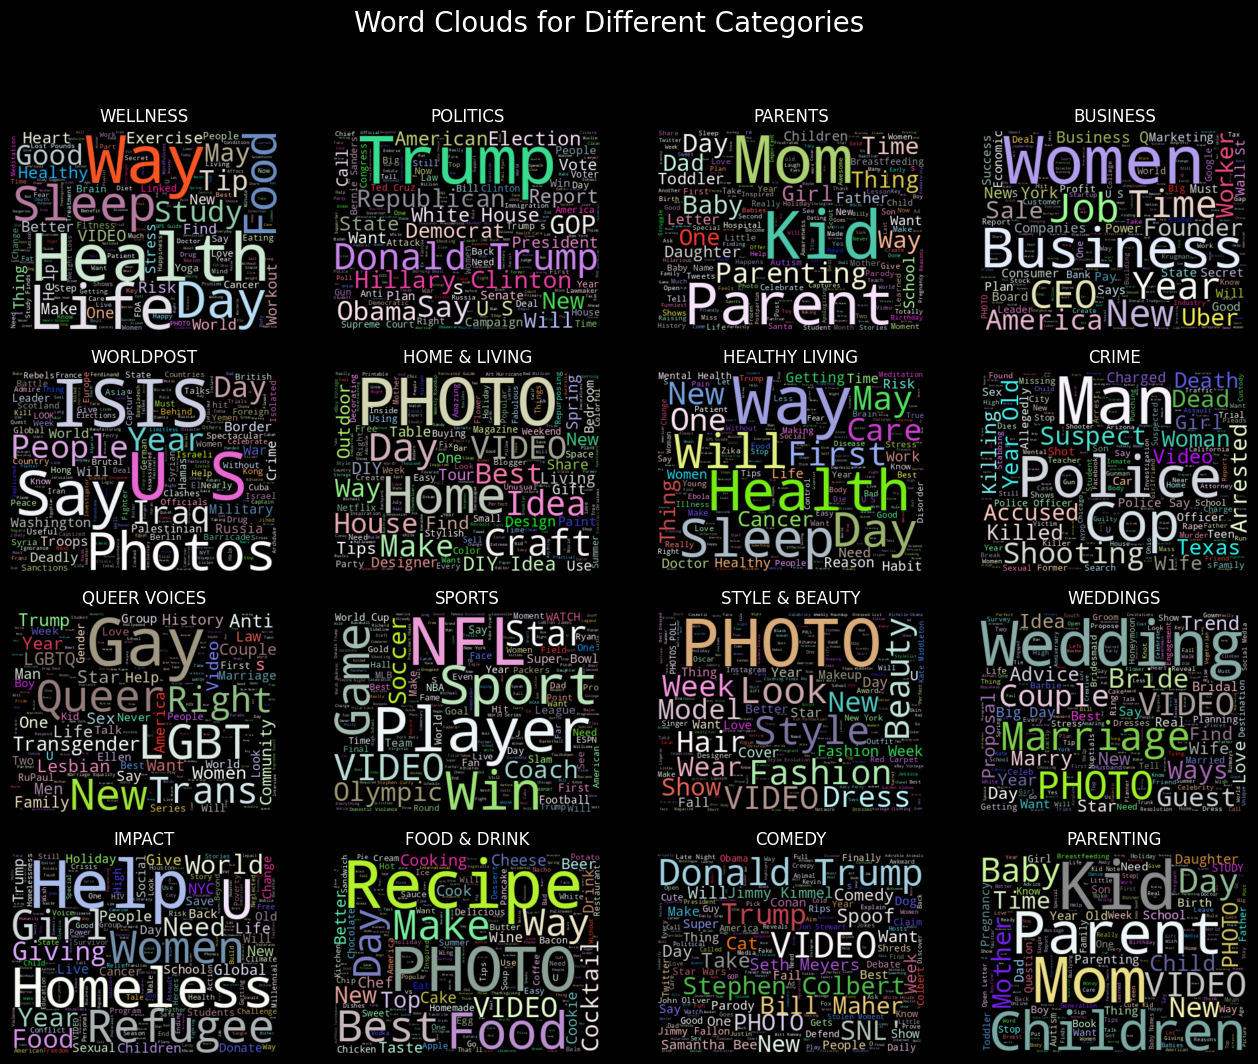

In [12]:
def random_color_func(word=None, font_size=None, position=None, orientation=None, font_path=None, random_state=None):
    h = int(360.0 * random.random())
    s = int(100.0 * random.random())
    l = int(50.0 * random.random()) + 50
    return "hsl({}, {}%, {}%)".format(h, s, l)

plt.style.use('dark_background')

fig, axes = plt.subplots(4, 4, figsize=(16, 12), subplot_kw=dict(xticks=[], yticks=[], frame_on=False))
for ax, category in zip(axes.flatten(), df_train['category'].unique()):
    wordcloud = WordCloud(width=400, height=300, random_state=42, max_font_size=100, background_color='black',
                          color_func=random_color_func, stopwords=STOPWORDS).generate(' '.join(df_train[df_train['category']==category]['headline']))
    ax.imshow(wordcloud, interpolation="bilinear")
    ax.set_title(category, color='white')
plt.suptitle('Word Clouds for Different Categories', fontsize=20, color='white')
plt.show()

In [14]:
df_train['date'] = pd.to_datetime(df_train['date'])

df_train['Month'] = df_train['date'].dt.to_period('M').astype(str)

monthly_counts = df_train['Month'].value_counts().sort_index().reset_index()
monthly_counts.columns = ['Month', 'Number of News Articles']

# time series line plot for monthly distribution
fig = px.line(
    monthly_counts,
    x='Month',
    y='Number of News Articles',
    labels={'Month': 'Month', 'Number of News Articles': 'Number of News Articles'},
    title='Time Series Distribution of Monthly News Articles',
    template='plotly_dark',
)

fig.show()

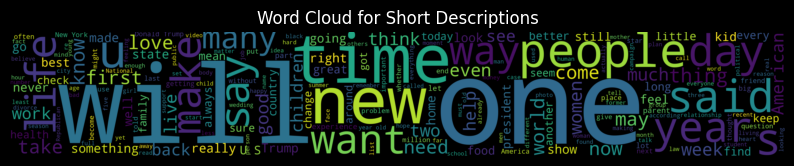

In [15]:
text = ' '.join(df_train['short_description'].dropna())

wordcloud = WordCloud(width=5000, height=800, background_color='black', colormap='viridis').generate(text)

plt.figure(figsize=(10, 19))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Short Descriptions')
plt.show()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


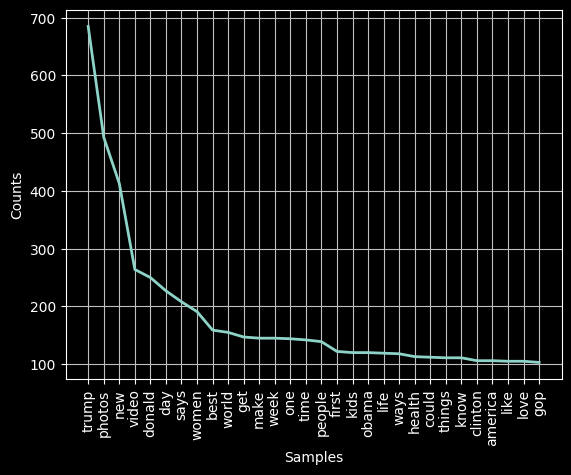

Sentiment: Sentiment(polarity=0.11280494495468456, subjectivity=0.4633834494081406)


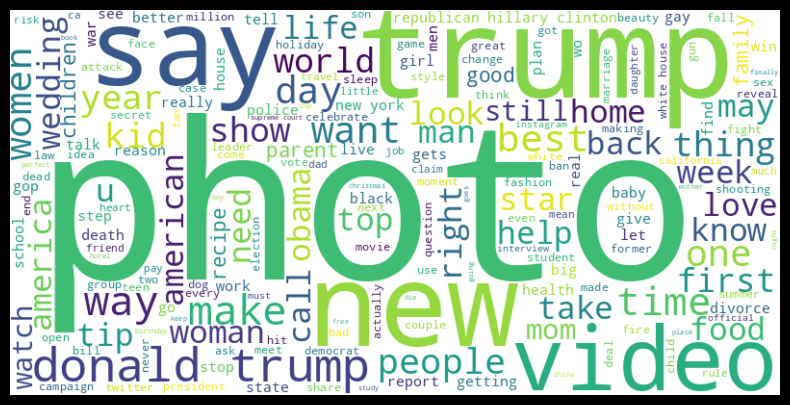

In [18]:
nltk.download('punkt')
nltk.download('stopwords')

def preprocess_text(text):
    tokens = word_tokenize(text.lower())

    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token.isalpha() and token not in stop_words]

    return ' '.join(tokens)

df_train['processed_headline'] = df_train['headline'].apply(preprocess_text)

df_train['processed_short_description'] = df_train['short_description'].apply(preprocess_text)

def word_frequency_analysis(text):
    word_frequencies = nltk.FreqDist(word_tokenize(text))
    word_frequencies.plot(30, cumulative=False)

def sentiment_analysis(text):
    sentiment = TextBlob(text).sentiment
    print(f'Sentiment: {sentiment}')

def generate_word_cloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

word_frequency_analysis(df_train['processed_headline'].str.cat(sep=' '))

sentiment_analysis(df_train['processed_headline'].str.cat(sep=' '))

generate_word_cloud(df_train['processed_headline'].str.cat(sep=' '))

In [31]:
import jsonlines

with open('/content/drive/MyDrive/train.jsonl', 'r') as train_file:
    train_data = list(jsonlines.Reader(train_file))

with open('/content/drive/MyDrive/dev.jsonl', 'r') as dev_file:
    dev_data = list(jsonlines.Reader(dev_file))

X_train = [sample['headline'] for sample in train_data]
y_train = [sample['category'] for sample in train_data]

X_dev = [sample['headline'] for sample in dev_data]
y_dev = [sample['category'] for sample in dev_data]

tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_dev_tfidf = tfidf_vectorizer.transform(X_dev)

classifier = MultinomialNB()

classifier.fit(X_train_tfidf, y_train)

y_pred = classifier.predict(X_dev_tfidf)

accuracy = accuracy_score(y_dev, y_pred)
print(f'Accuracy: {accuracy:.2f}')

print('\nClassification Report:')
print(classification_report(y_dev, y_pred))

print('\nConfusion Matrix:')
print(confusion_matrix(y_dev, y_pred))

# fine tune
param_grid = {'alpha': [0.01, 0.1, 0.5, 1.0]}
grid_search = GridSearchCV(classifier, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_tfidf, y_train)

best_params = grid_search.best_params_
print(f'\nBest Parameters: {best_params}')

best_classifier = MultinomialNB(alpha=best_params['alpha'])
best_classifier.fit(X_train_tfidf, y_train)

y_pred_tuned = best_classifier.predict(X_dev_tfidf)

accuracy_tuned = accuracy_score(y_dev, y_pred_tuned)
print(f'\nTuned Model Accuracy: {accuracy_tuned:.2f}')


print('\nTuned Model Classification Report:')
print(classification_report(y_dev, y_pred_tuned))

print('\nTuned Model Confusion Matrix:')
print(confusion_matrix(y_dev, y_pred_tuned))


Accuracy: 0.32

Classification Report:
                precision    recall  f1-score   support

          ARTS       0.00      0.00      0.00        11
ARTS & CULTURE       0.00      0.00      0.00        11
  BLACK VOICES       0.00      0.00      0.00        48
      BUSINESS       1.00      0.03      0.05        72
       COLLEGE       0.00      0.00      0.00        12
        COMEDY       1.00      0.03      0.05        36
         CRIME       1.00      0.03      0.06        33
CULTURE & ARTS       0.00      0.00      0.00         7
       DIVORCE       1.00      0.10      0.18        20
     EDUCATION       0.00      0.00      0.00        13
 ENTERTAINMENT       0.43      0.56      0.48       184
   ENVIRONMENT       0.00      0.00      0.00        10
         FIFTY       0.00      0.00      0.00        10
  FOOD & DRINK       0.74      0.21      0.33        67
     GOOD NEWS       0.00      0.00      0.00        16
         GREEN       0.00      0.00      0.00        21
HEALTHY 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.




Best Parameters: {'alpha': 0.1}

Tuned Model Accuracy: 0.41

Tuned Model Classification Report:
                precision    recall  f1-score   support

          ARTS       0.00      0.00      0.00        11
ARTS & CULTURE       0.00      0.00      0.00        11
  BLACK VOICES       0.35      0.17      0.23        48
      BUSINESS       0.47      0.19      0.27        72
       COLLEGE       0.00      0.00      0.00        12
        COMEDY       0.56      0.25      0.35        36
         CRIME       0.40      0.36      0.38        33
CULTURE & ARTS       0.00      0.00      0.00         7
       DIVORCE       0.55      0.30      0.39        20
     EDUCATION       0.00      0.00      0.00        13
 ENTERTAINMENT       0.41      0.61      0.49       184
   ENVIRONMENT       0.00      0.00      0.00        10
         FIFTY       0.00      0.00      0.00        10
  FOOD & DRINK       0.53      0.58      0.56        67
     GOOD NEWS       0.00      0.00      0.00        16
      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [34]:
with open('/content/drive/MyDrive/train.jsonl', 'r') as train_file:
    train_data = list(jsonlines.Reader(train_file))

with open('/content/drive/MyDrive/dev.jsonl', 'r') as dev_file:
    dev_data = list(jsonlines.Reader(dev_file))

with open('/content/drive/MyDrive/test.jsonl', 'r') as test_file:
    test_data = list(jsonlines.Reader(test_file))

X_train = [sample['headline'] for sample in train_data]
y_train = [sample['category'] for sample in train_data]

X_dev = [sample['headline'] for sample in dev_data]
y_dev = [sample['category'] for sample in dev_data]

X_test = [sample['headline'] for sample in test_data]
y_test = [sample['category'] for sample in test_data]

# Tokenize and pad the sequences
max_words = 5000
max_len = 100
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_dev_seq = tokenizer.texts_to_sequences(X_dev)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_dev_pad = pad_sequences(X_dev_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)


label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_dev_encoded = label_encoder.transform(y_dev)
y_test_encoded = label_encoder.transform(y_test)


model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128))
model.add(LSTM(512, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(512, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))


model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_pad, y_train_encoded, epochs=5, batch_size=128, validation_data=(X_dev_pad, y_dev_encoded))

# Evaluate the model
accuracy = model.evaluate(X_test_pad, y_test_encoded)[1]
print(f'Accuracy: {accuracy:.2f}')


Epoch 1/5
79/79 [==============================] - 353s 4s/step - loss: 3.3013 - accuracy: 0.1717 - val_loss: 3.0712 - val_accuracy: 0.2175
Epoch 2/5
79/79 [==============================] - 324s 4s/step - loss: 2.7754 - accuracy: 0.2910 - val_loss: 2.7423 - val_accuracy: 0.2995
Epoch 3/5
79/79 [==============================] - 320s 4s/step - loss: 2.3066 - accuracy: 0.3963 - val_loss: 2.6017 - val_accuracy: 0.3535
Epoch 4/5
79/79 [==============================] - 323s 4s/step - loss: 1.9340 - accuracy: 0.4766 - val_loss: 2.5573 - val_accuracy: 0.3730
Epoch 5/5
63/63 [==============================] - 23s 365ms/step - loss: 2.7001 - accuracy: 0.3750
Accuracy: 0.38


In [35]:
test_loss, test_accuracy = model.evaluate(X_test_pad, y_test_encoded)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

63/63 [==============================] - 40s 643ms/step - loss: 2.7001 - accuracy: 0.3750
Test Accuracy: 37.50%


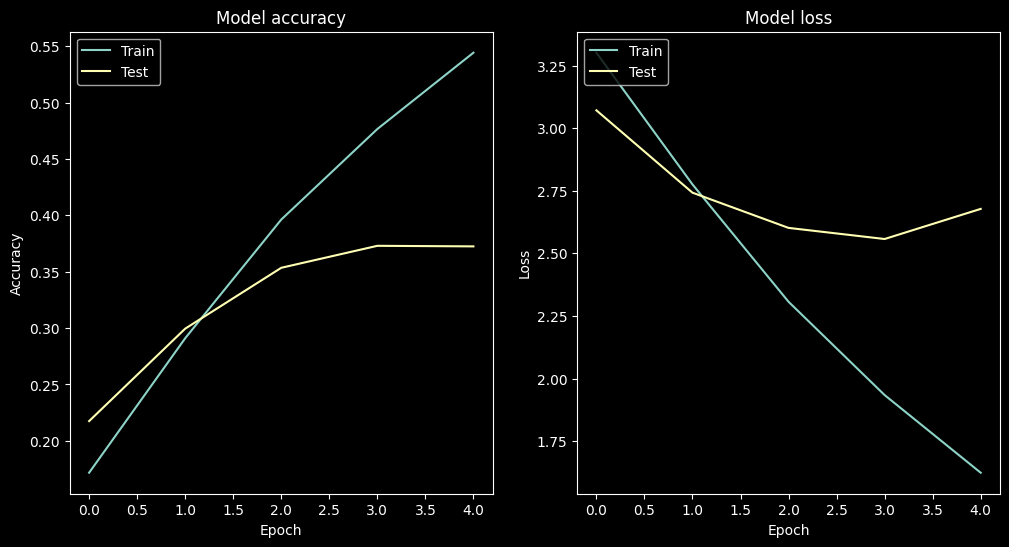

In [36]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()